In [3]:
import torch
import pickle
import numpy as np
import pandas as pd
import os
from typing import Tuple
import gymnasium as gym
import combinatorial_problems
from tqdm import tqdm
import copy

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Model and Experiment Loading and Analysis

In [4]:
def load_experiment(directory: str,
                    experiment_name: str
                    ) -> Tuple[torch.nn.Module, dict]:
    # Create experiment files
    exp_pt_file = os.path.join(directory, f'{experiment_name}.pt')
    exp_pkl_file = os.path.join(directory, f'{experiment_name}.pkl')
    
    # Load torch models and experiment data
    model = torch.load(exp_pt_file)
    with open(exp_pkl_file, 'rb') as jar:
        data = pickle.load(jar)
    return model, data

def evaluate_TSP(model: torch.nn.Module,
                 graph_size: int,
                 batch_size: int,
                 eval_epochs: int):
    problem_env = "combinatorial_problems/TravelingSalesman-v0"
    env = gym.vector.make(problem_env,
                num_nodes=graph_size,
                num_envs=batch_size,
                new_on_reset=True,
                asynchronous=False)
    rewards_over_batches = []
    for epoch in tqdm(range(eval_epochs)):
        state, info = env.reset()
        start_idx = info["agent_start_idx"]
        end_idx = start_idx
        done = False
        batch_rewards = 0
        while not done:
            graph_nodes = np.stack(info["nodes"])
            graph = torch.FloatTensor(graph_nodes).reshape(batch_size, graph_size, 2).to('cuda')

            

            # Only use with older model:
            #model.policy.reuse_graph_emb = False

            with torch.no_grad():
                # Compute node embeddings
                tmp_emb = model.policy.encoder(graph).detach()
                start_node = tmp_emb[np.arange(batch_size), start_idx, :].unsqueeze(1)
                end_node = tmp_emb[np.arange(batch_size), end_idx, :].unsqueeze(1)
                # Create problem context
                ctxt = torch.cat([start_node, end_node], dim=-1)
                # Generate Masks
                mask_emb_graph = torch.zeros(batch_size, 1, graph_size).bool().to('cuda')  # Empty Mask!
                masks = np.stack(info["mask"])
                mask_dec_graph = torch.tensor(masks).unsqueeze(1).to('cuda')
                reuse_embeding = False
                # Get prediction
                action = model(graph=graph,
                              ctxt=ctxt,
                              mask_emb_graph=mask_emb_graph,
                              mask_dec_graph=mask_dec_graph,
                              reuse_embeding=reuse_embeding,
                              explore=True,
                              re_compute_embedding=False).numpy()
            state, reward, terminated, truncated, info = env.step(action)
            end_idx = action.squeeze()
            batch_rewards += reward
            done = terminated.all() or truncated.all()
        rewards_over_batches.append(np.array(batch_rewards).mean())
        model.policy.graph_emb_vect = None
    eval_rewards = np.mean(rewards_over_batches)
    return eval_rewards

# Tested Experiment over 50 nodes, 60 epochs, and avg graph embedding

In [3]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_60_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

<AxesSubplot:>

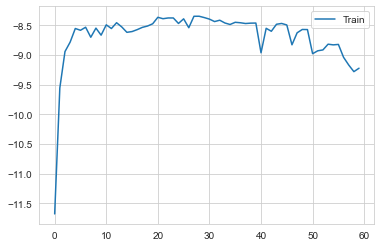

In [4]:
experiment_results.plot()

### Explore Performance on Different Problems

In [6]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [05:38<00:00, 42.28s/it]


In [12]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.923233
20,-4.269167
50,-7.494991
100,-12.629872


### Show Example Solution

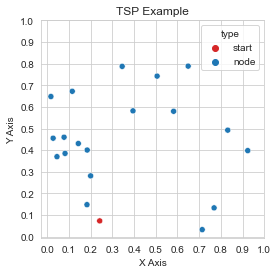

In [5]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [6]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-3.998506203728642


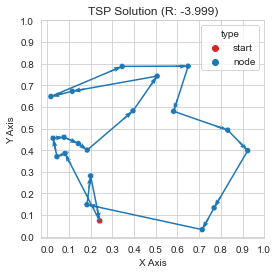

In [7]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Tested Experiment over 20 nodes, 60 epochs, and avg graph embedding

In [5]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_60_batch-len_128_problem_TSP_nodes_20_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

In [7]:
experiment_results[:10]

,Train
0,-5.355088
1,-4.576107
2,-4.522385
3,-4.484495
4,-4.422144
5,-4.422941
6,-4.377374
7,-4.328619
8,-4.279268
9,-4.243369


### Explore Performance on Different Problems

In [6]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [05:38<00:00, 42.28s/it]


In [12]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.923233
20,-4.269167
50,-7.494991
100,-12.629872


### Show Example Solution

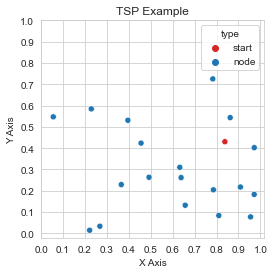

In [15]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [16]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-3.5129397706450036


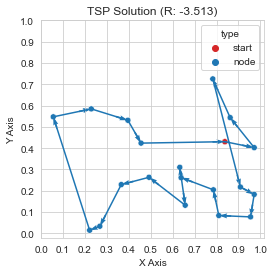

In [17]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Tested Experiment over 50 nodes, 60 epochs, and Persistence graph embedding

In [23]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_persistence_PAM_heads_8_layers_3_g-embedding_p_lr_0.0001_envs_128000_epochs_30_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

<AxesSubplot:>

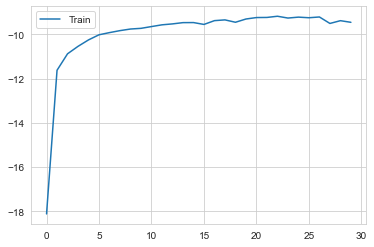

In [24]:
experiment_results.plot()

### Explore Performance on Different Problems

In [25]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

 12%|█▎        | 1/8 [06:02<42:19, 362.82s/it]


NameError: name 'model' is not defined

In [26]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.961898
20,-4.364180
50,-7.561092
100,-7.561092


### Show Example Solution

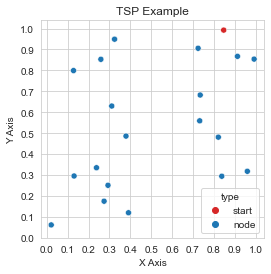

In [27]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [28]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-4.4368481472427765


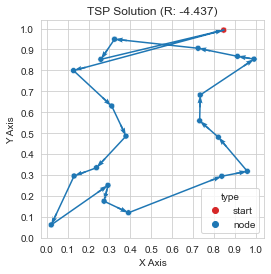

In [29]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()